# Example 3: Shorting and leveraged portfolios

This example follows from previous ones. If something in the preamble is confusing, it is explained there.

This example focuses on using the shorting constraints available to `Trad` and `WC` optimisations of `Portfolio`.

## 1. Downloading the data

In [1]:
# using Pkg
# Pkg.add.(["StatsPlots", "GraphRecipes", "YFinance", "Clarabel", "HiGHS", "CovarianceEstimation", "SparseArrays"])
using Clarabel, CovarianceEstimation, DataFrames, Dates, GraphRecipes, HiGHS, YFinance,
      PortfolioOptimiser, Statistics, StatsBase, StatsPlots, TimeSeries, LinearAlgebra,
      PrettyTables

fmt1 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return if isa(v, Number)
            "$(round(v*100, digits=3)) %"
        else
            v
        end
    end
end;

function stock_price_to_time_array(x)
    coln = collect(keys(x))[3:end] # only get the keys that are not ticker or datetime
    m = hcat([x[k] for k ∈ coln]...) #Convert the dictionary into a matrix
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end
assets = ["AAL", "AAPL", "AMC", "BB", "BBY", "DELL", "DG", "DRS", "GME", "INTC", "LULU",
          "MARA", "MCI", "MSFT", "NKLA", "NVAX", "NVDA", "PARA", "PLNT", "SAVE", "SBUX",
          "SIRI", "STX", "TLRY", "TSLA"]
Date_0 = "2019-01-01"
Date_1 = "2023-01-01"
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets));

## 2. Instantiating an instance of `Portfolio`.

In [2]:
portfolio = Portfolio(; prices = prices,
                      # Continuous optimiser.
                      solvers = Dict(:Clarabel => Dict(:solver => Clarabel.Optimizer,
                                                       :check_sol => (allow_local = true,
                                                                      allow_almost = true),
                                                       :params => Dict("verbose" => false))),
                      # MIP optimiser for the discrete allocation.
                      alloc_solvers = Dict(:HiGHS => Dict(:solver => HiGHS.Optimizer,
                                                          :check_sol => (allow_local = true,
                                                                         allow_almost = true),
                                                          :params => Dict("log_to_console" => false))));

In [3]:
mu_type = MuSimple()
cov_type = PortCovCor()
asset_statistics!(portfolio; mu_type = mu_type, cov_type = cov_type)

In [4]:
# Risk free rate.
rf = 3.5 / 100 / 252
# Risk aversion.
l = 2.0
# Objective function.
obj = MinRisk()
# Risk measure.
rm = SD()
# Money available to us.
investment = 6750;

## 3.1 Long-only portfolio

First we will optimise the portfolio without shorting and plot the weights and the efficient frontier.

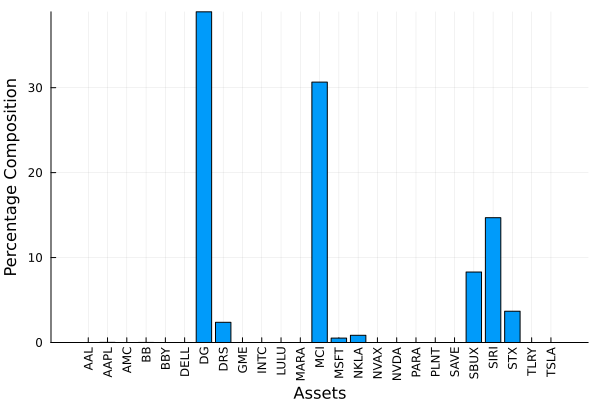

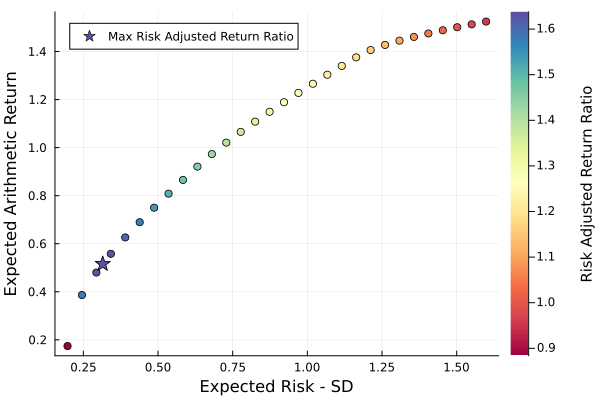

In [5]:
portfolio.short = false
portfolio.optimal[:ns] = optimise!(portfolio; rm = rm, obj = obj)
display(plot_bar(portfolio, :ns))
portfolio.frontier[:ns] = efficient_frontier!(portfolio; rm = rm, points = 30)
display(plot_frontier(portfolio, :ns))

We'll now allocate the portfolio according to our means. We'll use both allocation methods:

- Linear Mixed-integer Programming (LP): (default) can only allocate discrete integer shares and requires an MIP solver.
- Greedy algorithm, can round down to the nearest `integer + N*rounding`, but is not guaranteed to be globally optimal. The rounding also rounds down, as it ensures the investment will not be exceeded.

In [6]:
portfolio.optimal[:nsal] = allocate!(portfolio, :ns; method = LP(), investment = investment)
portfolio.optimal[:nsag] = allocate!(portfolio, :ns; method = Greedy(; rounding = 0.3),
                                     investment = investment);

Lets verify that the allocations used the money we have available. We'll also compare the would-be optimal portfolio.

Optimal portfolio

In [7]:
long_optimal_idx = portfolio.optimal[:ns].weights .>= 0
short_optimal_idx = .!long_optimal_idx
println("Optimal investment = $(sum(investment * portfolio.optimal[:ns].weights[long_optimal_idx]))")
println("Sum of weights = $(sum(portfolio.optimal[:ns].weights[long_optimal_idx]))")

Optimal investment = 6750.0
Sum of weights = 1.0


LP allocated portfolio

In [8]:
long_LP_idx = portfolio.optimal[:nsal].weights .>= 0
short_LP_idx = .!long_LP_idx
println("Allocation investment = $(dot(portfolio.latest_prices[long_LP_idx], portfolio.optimal[:nsal].shares[long_LP_idx]))")
println("Sum of weights = $(sum(portfolio.optimal[:nsal].weights[long_LP_idx]))")

Allocation investment = 6745.64430975914
Sum of weights = 0.9993547125569097


Greedy allocated portfolio

In [9]:
long_Greedy_idx = portfolio.optimal[:nsag].weights .>= 0
short_Greedy_idx = .!long_Greedy_idx
println("Allocation investment = $(dot(portfolio.latest_prices[long_Greedy_idx], portfolio.optimal[:nsag].shares[long_Greedy_idx]))")
println("Sum of weights = $(sum(portfolio.optimal[:nsag].weights[long_Greedy_idx]))")

Allocation investment = 6404.779709124566
Sum of weights = 0.9488562532036392


As you can see, the greedy algorithm doesn't make optimal use of the available investment.

Lets now see what the long-only portfolio looks like, in both optimal and allocated form.

In [10]:
pretty_table(DataFrame(; tickers = portfolio.assets,
                       # Optimal weights without shorting.
                       ns_w = portfolio.optimal[:ns].weights,
                       # Discretely allocated optimal weights without shorting.
                       # Linear programming.
                       nsal_w = portfolio.optimal[:nsal].weights,
                       # Discretely allocated shares without shorting.
                       # Linear programming.
                       nsal_s = portfolio.optimal[:nsal].shares,
                       # Discretely allocated optimal weights without shorting.
                       # Greedy algorithm.
                       nsag_w = portfolio.optimal[:nsag].weights,
                       # Discretely allocated shares without shorting.
                       # Greedy algorithm.
                       nsag_s = portfolio.optimal[:nsag].shares))

┌─────────┬─────────────┬─────────────┬────────┬─────────────┬─────────┐
│ tickers │        ns_w │      nsal_w │ nsal_s │      nsag_w │  nsag_s │
│  String │     Float64 │     Float64 │  Int64 │     Float64 │ Float64 │
├─────────┼─────────────┼─────────────┼────────┼─────────────┼─────────┤
│     AAL │  1.86436e-7 │         0.0 │      0 │         0.0 │     0.0 │
│    AAPL │ 0.000111343 │         0.0 │      0 │         0.0 │     0.0 │
│     AMC │  2.93066e-7 │         0.0 │      0 │         0.0 │     0.0 │
│      BB │   2.4079e-5 │ 0.000482963 │      1 │ 0.000144889 │     0.3 │
│     BBY │  3.96715e-7 │         0.0 │      0 │         0.0 │     0.0 │
│    DELL │  2.26042e-6 │         0.0 │      0 │         0.0 │     0.0 │
│      DG │    0.389326 │    0.391608 │     11 │    0.366688 │    10.3 │
│     DRS │   0.0237275 │   0.0246133 │     13 │     0.02272 │    12.0 │
│     GME │  2.25598e-7 │         0.0 │      0 │         0.0 │     0.0 │
│    INTC │  1.70134e-6 │         0.0 │      0 │   

## 3.2 Shorting

Enabling shorting is very simple. This will allow negative weights, which correspond to shorting portfolios. It is generally a good idea to start with little to no leverage.

In [11]:
portfolio.short = true;

How short- or long-heavy we want to be is mediated by the `short_u` and `long_u` properties. They set the upper bound for the absolute value of the sum of the short and long weights respectively.

- `short_u`: the absolute value of the sum of the short weights will be less than this.
- `long_u`: the sum of the long weights will be less than this.

These values multiply the cash at our disposal when we allocate the portfolio. So when `allocate!` is called, the long investment will be `investment * long_u`. And if shorting is enabled, the short investment (the amount shorted) will be `short_u * investment`.

Lets short the market whithout reinvesting the earnings, meaning we'll have a cash reserve in our balance that is equal to the short sale value. You can change this by increasing `long_u`, if you set it to `1 + short_u` it means the profits from short selling will be reinvested into the portfolio.

We will use the default values.

In [12]:
# The absolute value of the sum of the short weights is equal to `0.2`.
portfolio.short_u = 0.2
# Long weights add up to `1.0`.
portfolio.long_u = 1;

The portfolio `budget = long_u - short_u` gives us the leverage characteristics of the portfolio. This is a property that is automatically computed and cannot be cahnged. There are verious scenarios that `budget` describes.

- `budget < 0`: the short sale value of the portfolio is higher than the long-sale value.
- `budget == 0`: the short and long values of the portfolio are equal. The market neutral portfolio is found by maximising the return given these conditions.
- `0 < budget < 1`: the portfolio is under-leveraged, meaning there is a cash reserve that is not being used.
- ` budget == 1`: the portfolio has no leverage. If shorting is enabled, this means the profits from shorting are being invested in long positions.
- `budget < 1`: the portfolio is leveraged, meaning it's using more money than is available.

Here the portfolio is under-leveraged.

In [13]:
portfolio.budget == 0.8

true

Lets optimise the short-long portfolio.

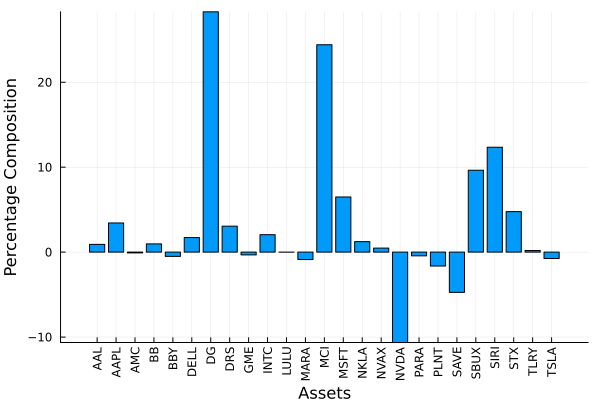

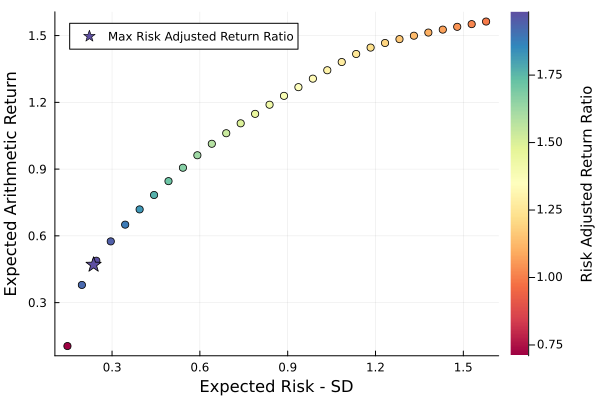

In [14]:
portfolio.optimal[:s] = optimise!(portfolio; rm = rm, obj = obj)
display(plot_bar(portfolio, :s))
portfolio.frontier[:s] = efficient_frontier!(portfolio; rm = rm, points = 30)
display(plot_frontier(portfolio, :s))

Lets allocate the short-long portfolio.

In [15]:
# Allocating the short-long portfolio.
portfolio.optimal[:sal] = allocate!(portfolio, :s; investment = investment)
portfolio.optimal[:sag] = allocate!(portfolio, :s; method = Greedy(; rounding = 0.3),
                                    investment = investment);

Lets verify that the allocations used the money we have available.

Optimal portfolio

In [16]:
long_optimal_idx = portfolio.optimal[:s].weights .>= 0
short_optimal_idx = .!long_optimal_idx
println("Optimal investment")
println("long = $(sum(investment * portfolio.optimal[:s].weights[long_optimal_idx]))")
println("short = $(sum(investment * portfolio.optimal[:s].weights[short_optimal_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:s].weights[long_optimal_idx]))")
println("short = $(sum(portfolio.optimal[:s].weights[short_optimal_idx]))")

Optimal investment
long = 6749.929912311713
short = -1349.9299123117128
Sum of weights
long = 0.9999896166387723
short = -0.1999896166387723


LP allocated portfolio

In [17]:
long_LP_idx = portfolio.optimal[:sal].weights .>= 0
short_LP_idx = .!long_LP_idx
println("Allocation investment")
println("long = $(dot(portfolio.latest_prices[long_LP_idx], portfolio.optimal[:sal].shares[long_LP_idx]))")
println("short = $(dot(portfolio.latest_prices[short_LP_idx], portfolio.optimal[:sal].shares[short_LP_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:sal].weights[long_LP_idx]))")
println("short = $(sum(portfolio.optimal[:sal].weights[short_LP_idx]))")

Allocation investment
long = 6749.9953536987305
short = -1347.4847583770752
Sum of weights
long = 0.9999993116590711
short = -0.19962737161141852


Greedy allocated portfolio

In [18]:
long_Greedy_idx = portfolio.optimal[:sag].weights .>= 0
short_Greedy_idx = .!long_Greedy_idx
println("Allocation investment")
println("long = $(dot(portfolio.latest_prices[long_Greedy_idx], portfolio.optimal[:sag].shares[long_Greedy_idx]))")
println("short = $(dot(portfolio.latest_prices[short_Greedy_idx], portfolio.optimal[:sag].shares[short_Greedy_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:sag].weights[long_Greedy_idx]))")
println("short = $(sum(portfolio.optimal[:sag].weights[short_Greedy_idx]))")

Allocation investment
long = 6234.454080057145
short = -1236.7210865020752
Sum of weights
long = 0.9236228266751326
short = -0.18321793874104814


Here's what the short-long portfolio looks like. See how this differs from the long-only portfolio.

In [19]:
pretty_table(DataFrame(; tickers = portfolio.assets,
                       # Optimal weights with shorting.
                       s_w = portfolio.optimal[:s].weights,
                       # Discretely allocated optimal weights with shorting.
                       # Linear programming.
                       sal_w = portfolio.optimal[:sal].weights,
                       # Discretely allocated shares with shorting.
                       # Linear programming.
                       sal_s = portfolio.optimal[:sal].shares,
                       # Discretely allocated optimal weights with shorting.
                       # Greedy algorithm.
                       sag_w = portfolio.optimal[:sag].weights,
                       # Discretely allocated shares with shorting.
                       # Greedy algorithm.
                       sag_s = portfolio.optimal[:sag].shares))

┌─────────┬──────────────┬─────────────┬───────┬─────────────┬─────────┐
│ tickers │          s_w │       sal_w │ sal_s │       sag_w │   sag_s │
│  String │      Float64 │     Float64 │ Int64 │     Float64 │ Float64 │
├─────────┼──────────────┼─────────────┼───────┼─────────────┼─────────┤
│     AAL │   0.00917505 │  0.00942222 │     5 │  0.00753778 │     4.0 │
│    AAPL │    0.0343343 │   0.0381391 │     2 │   0.0305113 │     1.6 │
│     AMC │ -0.000920751 │        -0.0 │     0 │        -0.0 │    -0.0 │
│      BB │   0.00972662 │   0.0106252 │    22 │  0.00965926 │    20.0 │
│     BBY │  -0.00498257 │        -0.0 │     0 │        -0.0 │    -0.0 │
│    DELL │    0.0171637 │   0.0171565 │     3 │   0.0171565 │     3.0 │
│      DG │     0.282904 │    0.284806 │     8 │    0.249205 │     7.0 │
│     DRS │     0.030533 │   0.0302933 │    16 │      0.0284 │    15.0 │
│     GME │  -0.00329396 │ -0.00273481 │    -1 │ -0.00273481 │    -1.0 │
│    INTC │    0.0205213 │   0.0188784 │     5 │   

## 3.3 Shorting with reinvestment

In this section we'll reinvest the money made from short selling, this can be acomplished by setting the value of `long_u = 1 + short_u`.

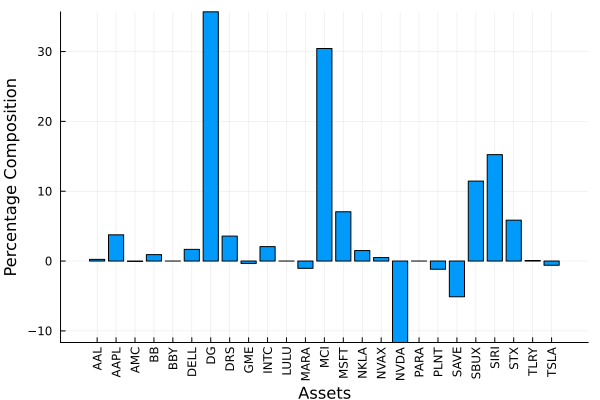

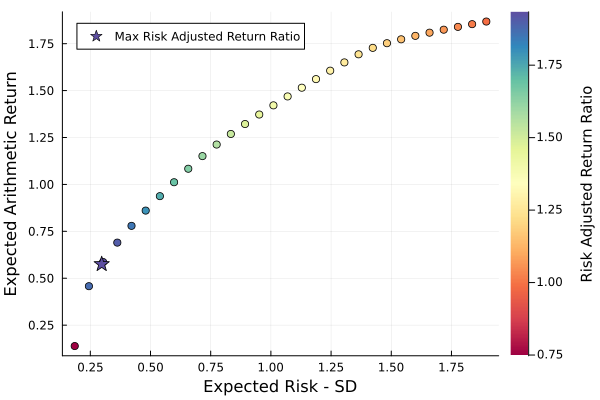

In [20]:
portfolio.short = true

# The absolute value of the sum of the short weights is equal to `0.2`.
portfolio.short_u = 0.2
# Long weights add up to `1.2`, which means reinvesting the gains from shorting.
portfolio.long_u = 1 + portfolio.short_u
# No leverage.
portfolio.budget == 1

portfolio.optimal[:sr] = optimise!(portfolio; rm = rm, obj = obj)
display(plot_bar(portfolio, :sr))
portfolio.frontier[:sr] = efficient_frontier!(portfolio; rm = rm, points = 30)
display(plot_frontier(portfolio, :sr))

Lets allocate the short-long portfolio.

In [21]:
# Allocating the short-long portfolio.
portfolio.optimal[:sral] = allocate!(portfolio, :sr; investment = investment)
portfolio.optimal[:srag] = allocate!(portfolio, :sr; method = Greedy(; rounding = 0.3),
                                     investment = investment);

Lets verify that the allocations used the money we have available.

Optimal portfolio

In [22]:
long_optimal_idx = portfolio.optimal[:sr].weights .>= 0
short_optimal_idx = .!long_optimal_idx
println("Optimal investment")
println("long = $(sum(investment * portfolio.optimal[:sr].weights[long_optimal_idx]))")
println("long = $(investment + abs(sum(investment * portfolio.optimal[:sr].weights[short_optimal_idx]))) = investment + short_profit")
println("short = $(sum(investment * portfolio.optimal[:sr].weights[short_optimal_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:sr].weights[long_optimal_idx]))")
println("short = $(sum(portfolio.optimal[:sr].weights[short_optimal_idx]))")

Optimal investment
long = 8099.9809297691345
long = 8099.980929769134 = investment + short_profit
short = -1349.9809297691338
Sum of weights
long = 1.1999971747806124
short = -0.19999717478061238


LP allocated portfolio

In [23]:
long_LP_idx = portfolio.optimal[:sral].weights .>= 0
short_LP_idx = .!long_LP_idx
println("Allocation investment")
println("long = $(dot(portfolio.latest_prices[long_LP_idx], portfolio.optimal[:sral].shares[long_LP_idx]))")
println("long ≈ $(investment + abs(dot(portfolio.latest_prices[short_LP_idx], portfolio.optimal[:sral].shares[short_LP_idx]))) ≈ investment + short_profit")
println("short = $(dot(portfolio.latest_prices[short_LP_idx], portfolio.optimal[:sral].shares[short_LP_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:sral].weights[long_LP_idx]))")
println("short = $(sum(portfolio.optimal[:sral].weights[short_LP_idx]))")

Allocation investment
long = 8099.028953790665
long ≈ 8095.019401550293 ≈ investment + short_profit
short = -1345.019401550293
Sum of weights
long = 1.1998561413023208
short = -0.1992621335630064


Greedy allocated portfolio

In [24]:
long_Greedy_idx = portfolio.optimal[:srag].weights .>= 0
short_Greedy_idx = .!long_Greedy_idx
println("Allocation investment")
println("long = $(dot(portfolio.latest_prices[long_Greedy_idx], portfolio.optimal[:srag].shares[long_Greedy_idx]))")
println("long ≈ $(investment + abs(dot(portfolio.latest_prices[short_Greedy_idx], portfolio.optimal[:srag].shares[short_Greedy_idx]))) ≈ investment + short_profit")
println("short = $(dot(portfolio.latest_prices[short_Greedy_idx], portfolio.optimal[:srag].shares[short_Greedy_idx]))")
println("Sum of weights")
println("long = $(sum(portfolio.optimal[:srag].weights[long_Greedy_idx]))")
println("short = $(sum(portfolio.optimal[:srag].weights[short_Greedy_idx]))")

Allocation investment
long = 7547.8587051391605
long ≈ 7987.211822891235 ≈ investment + short_profit
short = -1237.2118228912354
Sum of weights
long = 1.118201289650246
short = -0.18329064042833118


Here's what the short-long portfolio looks like when we reinvest profits from shorting.

In [25]:
pretty_table(DataFrame(; tickers = portfolio.assets,
                       # Optimal weights with shorting.
                       s_w = portfolio.optimal[:sr].weights,
                       # Discretely allocated optimal weights with shorting.
                       # Linear programming.
                       sal_w = portfolio.optimal[:sral].weights,
                       # Discretely allocated shares with shorting.
                       # Linear programming.
                       sal_s = portfolio.optimal[:sral].shares,
                       # Discretely allocated optimal weights with shorting.
                       # Greedy algorithm.
                       sag_w = portfolio.optimal[:srag].weights,
                       # Discretely allocated shares with shorting.
                       # Greedy algorithm.
                       sag_s = portfolio.optimal[:srag].shares))

┌─────────┬──────────────┬─────────────┬───────┬─────────────┬─────────┐
│ tickers │          s_w │       sal_w │ sal_s │       sag_w │   sag_s │
│  String │      Float64 │     Float64 │ Int64 │     Float64 │ Float64 │
├─────────┼──────────────┼─────────────┼───────┼─────────────┼─────────┤
│     AAL │   0.00234538 │  0.00188444 │     1 │  0.00244978 │     1.3 │
│    AAPL │    0.0375589 │   0.0381391 │     2 │   0.0305113 │     1.6 │
│     AMC │ -0.000592252 │        -0.0 │     0 │ -0.00180889 │    -0.3 │
│      BB │   0.00918785 │   0.0091763 │    19 │  0.00869333 │    18.0 │
│     BBY │  -2.37401e-7 │        -0.0 │     0 │        -0.0 │    -0.0 │
│    DELL │    0.0167517 │   0.0171565 │     3 │   0.0131533 │     2.3 │
│      DG │     0.356884 │    0.356008 │    10 │    0.320407 │     9.0 │
│     DRS │    0.0356709 │   0.0359733 │    19 │     0.03408 │    18.0 │
│     GME │  -0.00346536 │ -0.00546963 │    -2 │ -0.00355526 │    -1.3 │
│    INTC │    0.0206067 │   0.0188784 │     5 │   

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*